# ANALYSIS
***

Now that we have cleaned data, we can run some analyses on it. We collected information on **81** different prominent (primarily english-speaking) channels. The reason we selected primarily english-speaking channels is so that we can perform NLP tasks on them. From each channel, we collected information on their last **50** uploads. From here, we can explore these data to see if we can gain insights into the performance, demographics, and more, about these channels.

**Channel Selection Criteria**
- greater than or equal to 1 million subscribers
- primarily english-speaking, or audience is primarily english-speaking


Note: we also tried to obtain a sample of channels coming from a wide range of different genres. It's worth noting that there are roughly 35,000 channels with over 1 million subs, according to [Awesome Creator Academy](https://www.awesomecreatoracademy.com/blog/how-many-youtube-channels-have-1-million-subscribers), so our sample size is rather small in the context of the entire platform. Hence, we tried to generalize our selections across a wide set of genres to better represent the channels that have a marked influence on the platform. To that end, the same source estimates that there exists roughly 150 million+ channels with less than 1 million subscribers, though their overall impact on the platform as a whole is much less significant.

<br>

### Terminology:
- "viral video"
    - a video whose view count exceeds the channel's subscriber count
- "subscriber base"
    - the number of accounts subscribed to a YouTube channel


<br>

## Research Questions
- *what words are most commonly used in video titles?*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import preprocessing
import analyzer
from collections import Counter
pd.options.mode.chained_assignment = None
reload(preprocessing)
reload(analyzer)

<module 'analyzer' from 'C:\\Users\\Matt\\DataspellProjects\\Youtube Data Analytics\\analyzer.py'>

In [2]:
videos = pd.read_csv(preprocessing.CLEAN_DATA.joinpath('videos_cleaned.csv'))
vid_df = pd.DataFrame(videos)

channel_info = pd.read_csv(preprocessing.DATA.joinpath('channels.csv'))
channel_df = pd.DataFrame(channel_info)
vid_df.sample(10)

,video_id,channel_name,description,video_title,upload_date,length,num_views,length_secs
1045,1fZJVU44iSI,Jubilee,NaN,Should parents be allowed to ban topics for sc...,2023-08-03,0:00:59,35685,59
2652,JnVtpgCNLA8,HasanAbi,More like the ONLY perspective we've been hear...,THIS PRO-ISRAEL VIDEO IS INSANE (ft. Zachary F...,2023-10-23,1:45:53,230226,6353
1215,93puNntly5Y,Gibi ASMR,This #Sponsored video is brought to you by @Au...,"Fastest ASMR | Color Analysis, Dog Trainer, Ta...",2023-09-06,0:15:11,868813,911
2897,erAuinBotBQ,Vsauce,"d1, d2, d3, d4, d5, d6, d7, d8, d9, d10\nhttp:...",Denary Dice,2023-04-25,0:01:00,17019703,60
1727,GK4_G33fXFU,shane,BINGE all 8 Episodes NOW! https://www.youtube....,The Secrets of Jake Paul,2018-10-11,0:38:15,17151738,2295
957,-xeyAMhmw7k,Cody Ko,Full video coming Monday,CodyKo Unreleased IRONMAN Video Preview,2023-08-12,0:00:43,128517,43
3553,WLcMyiB2FQk,Drawfee Show,"Karina challenges Nathan, Jacob, and Julia to ...",Drawing Celebrities Based Only on Their Vibes,2023-10-10,0:51:41,170619,3101
2747,EtT-VhooPws,jacksepticeye,This is such a real feeling horror game that i...,Realistic body cam horror game,2023-05-20,0:15:07,1320467,907
2904,WNYoK3PXDEc,NBA,Check out some of the top plays of the opening...,Top Plays Of NBA Opening Night Since 2014👀,2023-10-23,0:35:36,36098,2136
912,M81-GM0mTc4,LastWeekTonight,"John Oliver discusses Ron DeSantis, his track ...",Ron DeSantis: Last Week Tonight with John Oliv...,2023-03-06,0:25:38,9836493,1538


In [3]:
def search_channel(channel_name: str):
    return vid_df.loc[vid_df['channel_name'] == channel_name] if channel_name in channel_df['channelName'].tolist() else vid_df.loc[vid_df['channel_name'].str.contains(channel_name)]

## I. Upload Schedules
---

Suppose we wish to answer the question: *Which YouTube channel post most frequently?*
To do this, we must find a way to compare the upload schedules among various channels. Given that we have the dates of each channel's previous 50 uploads, we can perform a few calculations that will lead us to an answer.

Before answering this graphically, let's understand the intuition behind these calculations numerically.

Note that the timespan for each channel's last 50 uploads will differ wildly, depending on how many videos the channel publishes a day. In the case of News channels, we'd expect this to relatively high, whereas with Animation channels, this may be much lower due to the length of time a single video takes to produce. Hence, it may be more useful to calculate a timespan relative to each channel, rather than picking a time interval to compare each channel against and counting the number of videos each one posted within that timespan.

Therefore, for each channel we will calculate an *upload_timespan* and *upload_rate*. The former represents the duration between their most recent upload, and their 50th most recent upload. Since *upload_timespan* is a relative measure, *upload_rate* will be relative as well. *upload_rate* can be interpreted as the average number of videos the channel uploads per day (based on their upload schedule from their last 50 videos), which will be inversely proportional to their respective *upload_timespan*.

These measurements will allow us to numerically determine which channels post most frequently. Channels with the highest *upload_timespan* represent the channels that post videos most infrequently, or at the very least, have large gaps between uploads. Hence, if a channel's last 50 uploads were all posted in 1 day, we'd expect their *upload_rate* to be 50. Of course, its worth mentioning that this calculation does not take into account the lengths of the videos themselves, so this should not be interpreted as a channel's "productivity", or anything related to the content of the videos themselves.

In [4]:
import datetime
def calculate_upload_time_span(channel_name: str):
    """calculates the timespan between the channel's last 50 uploads"""
    dates = pd.DataFrame(search_channel(channel_name)['upload_date']).sort_values(by='upload_date', ascending=True).to_numpy()
    return datetime.datetime.strptime(dates.flatten()[-1],'%Y-%m-%d') - datetime.datetime.strptime(dates.flatten()[0], '%Y-%m-%d')
# """approximates the length of time it took for the channel to release its last 50 videos"""
def calculate_upload_rate(channel_name: str):
    upload_rate = len(search_channel(channel_name)['upload_date'].to_list()) / (calculate_upload_time_span(channel_name).total_seconds() / (60 * 60 * 24))
    return round(upload_rate, 2)

In [5]:
new_df = pd.DataFrame(channel_df['channelName'])
new_df['upload_timespan'] = new_df['channelName'].apply(lambda x: calculate_upload_time_span(x))
new_df['uploads_per_day'] = new_df['channelName'].apply(lambda x: calculate_upload_rate(x))
new_df.sort_values(by='uploads_per_day', ascending=False)[:10]

,channelName,upload_timespan,uploads_per_day
60,ESPN,1 days,50.00
4,NBC News,1 days,50.00
12,CBS News,1 days,50.00
58,NBA,4 days,12.50
1,CNN,4 days,12.50
11,MLB,4 days,12.50
37,The Tonight Show Starring Jimmy Fallon,6 days,8.33
50,BBC News,7 days,7.14
48,The Majority Report w/ Sam Seder,7 days,7.14
44,Guardian News,8 days,6.25


From this table, we can see the 10 channels with the highest upload frequencies, which rather unsurprisingly, appears to entirely contain cable TV shows and News networks.
Next, let's see how this result compares to an absolute measurement of upload frequency.

Below we define the function `plot_upload_dates()`, which plots each channel provided to it as its own timeline of upload dates, where each dot on their respective timeline represents the day the channel uploaded.
For channels that post very frequently, their lines should be rather short, and dense with dots. This will also allow us to observe any large gaps between posts for certain channels.

In [6]:
def plot_upload_dates(channel_names):

    if isinstance(channel_names, str):
        channel_names = [channel_names]

    for i, channel_name in enumerate(channel_names):
        df = search_channel(channel_name)
        date_strings = df['upload_date']
        dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in date_strings]
        y_values = [i + 1] * len(dates)
        plt.plot(dates, y_values, marker='o', linestyle='-', label=channel_name)

    plt.xlabel('Date')
    plt.title('Last 50 Upload Dates by Channel')
    plt.xticks(rotation=45)
    plt.legend()
    plt.yticks([])
    plt.show()

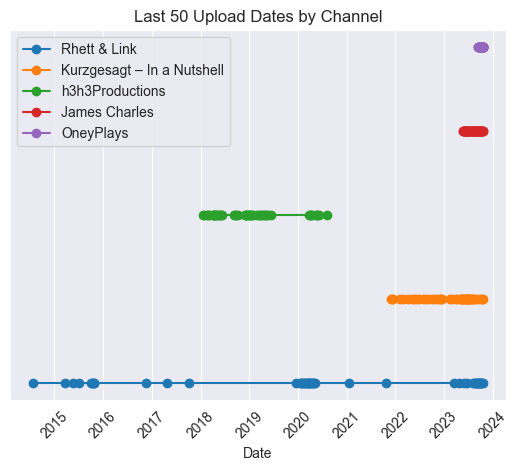

In [7]:
# random_channels = pd.DataFrame(channel_df['channelName'].sample(5))['channelName'].to_list()
# this list was generated at random, but was initialized here, so it doesn't change between runs
random_channels = ['Rhett & Link', 'Kurzgesagt – In a Nutshell', 'h3h3Productions', 'James Charles', 'OneyPlays']
plot_upload_dates(random_channels)

This graph encodes a lot of information pertaining to the channels and their upload schedules.
- Among the sample chosen, we see that **OneyPlays** is the most frequent uploader, given that their timeline is the shortest and most densely packed with dots.
- We can also determine that the most inconsistent uploader of the sample is the channel **Rhett & Link**, whose timeline is the longest, which can be explained by long gaps between uploads in the past, though it appears they post  quite frequently as of late.
- Lastly, we can see that the channel **h3h3productions** appears to be defunct, since their timeline stops around mid-2020 (and checking the site, this is confirmed to be true).

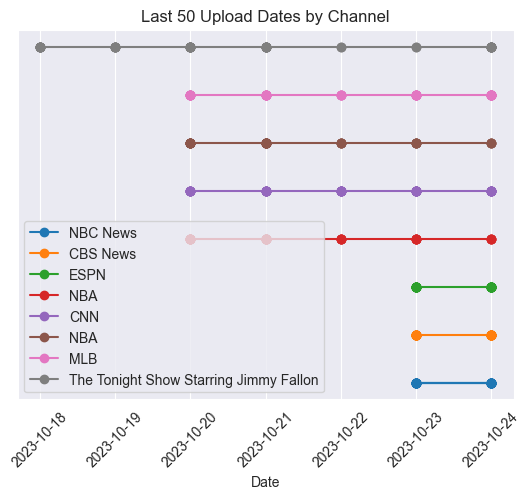

In [8]:
channels = ['NBC News', 'CBS News', 'ESPN', 'NBA', 'CNN', 'NBA', 'MLB', 'The Tonight Show Starring Jimmy Fallon']
plot_upload_dates(channels)

Note that by plugging in the channels we found had the highest *upload_rates*, we see that their upload schedules are quite uniform, and that they post multiple videos a day. According to our data, **NBC News** and **CBS News** are the most frequent posters.

## II. Video Duration
___

Next, we can determine which channel (on average) posts the most content in terms of video duration. First, we must calculate the *average_video_length*, which can be obtained by taking the mean of their video durations.
We must be careful though, since this value is highly susceptible to the nature of the content itself, i.e. whether the uploads considered in this calculation are a "typical video", a Short, or a stream. What constitutes a "typical video" for a channel varies widely, isn't very straightforward, and requires a strong understanding of the channel's themselves. Many channels also engage their audience with alternative forms of content, such as livestreams, which are long-form in nature, or Shorts, which as the name implies, are quite short and typically are less than a minute in length. It's important to keep this in mind going forward, since these will heavily skew the values we obtain when calculating the average video duration.

Currently, the YouTube API lacks a way to specify what form of content the upload falls under, but for our purposes, we will assume any video shorter than 1 minute qualifies as a Short, and any over 1 hour will be considered a livestream (only if videos of that length are uncommon for the channel).

In [9]:
from datetime import timedelta

def calculate_avg_video_duration(channel_name: str):
    """calculates arithmetic mean of video lengths"""
    total_duration = timedelta()
    durations = pd.DataFrame(search_channel(channel_name))['length'].tolist()
    for time_str in durations:
        hours, minutes, seconds = map(int, time_str.split(":"))
    duration = timedelta(hours=hours, minutes=minutes, seconds=seconds)
    total_duration += duration
    return str(total_duration)

def classify_upload_type(time_str: str, channel_name: str):
    """assign the entry a category based on its video length and the average duration of videos from the channel"""
    channel_mean_upload_duration = calculate_avg_video_duration(channel_name)
    mean_duration = analyzer.duration_to_secs(channel_mean_upload_duration)
    duration_ = analyzer.duration_to_secs(time_str)

    if duration_ >= timedelta(hours=1) and mean_duration <= duration_:
        return 'medium'
    elif duration_ <= timedelta(minutes=1) and mean_duration > duration_:
        return 'short'
    elif duration_ >= timedelta(hours=1) and mean_duration >= timedelta(hours=1):
        return 'long'
    elif duration_ <= timedelta(minutes=1) and mean_duration <= timedelta(minutes=1):
        return 'short'
    else:
        return 'medium'

In [10]:
channels = channel_df['channelName'].tolist()
channel_df['avg_upload_duration'] = channel_df['channelName'].apply(lambda x: calculate_avg_video_duration(x))
channel_df[['channelName', 'viewCount', 'subscriberCount', 'videoCount', 'avg_upload_duration']]

,channelName,viewCount,subscriberCount,videoCount,avg_upload_duration
0,Bon Appétit,1806695724,6380000,1543,0:00:24
1,CNN,14843457695,15700000,161812,0:10:40
2,PBS Space Time,428817752,2960000,367,0:20:30
3,Gordon Ramsay,3941028890,20200000,1585,1:35:12
4,NBC News,6348059328,9070000,57204,0:03:40
...,...,...,...,...,...
76,Philip DeFranco,1928011589,6480000,1748,0:19:55
77,The Daily Show,5405189122,10500000,5405,0:17:01
78,Jarvis Johnson,239388514,2040000,146,0:23:22
79,Dude Perfect,16674697235,59800000,400,0:21:03


In [11]:
vid_df['content_type'] = list(map(lambda x, y: classify_upload_type(x, y), vid_df['length'], vid_df['channel_name']))
vid_df.sample(5)

,video_id,channel_name,description,video_title,upload_date,length,num_views,length_secs,content_type
1604,qd791fyKAtA,Domics,Livestreamed on twitch:\nhttps://www.twitch.tv...,BRB,2022-03-06,1:04:55,1085014,3895,medium
161,zyB_1KfDbq8,Gordon Ramsay,From traditional Italian meals to vegetarian I...,Will Gordon Like Their Italian & Indian Menus?...,2023-10-07,1:30:29,57972,5429,long
2848,FQMHYbWsRsk,Jaiden Animations,Mario Kaizo haha oh wow oh no\nCheck out Ryu! ...,The Hardest Mario Game Ever,2021-09-26,0:17:39,23226168,1059,medium
1495,vmzjteVCccg,Unbox Therapy,Check out the OPPO Find N2 Flip: https://www.o...,The Perfect Smartphone For...,2023-07-24,0:00:59,159198,59,short
3354,KudedLV0tP0,Taylor Swift,Get tickets now to see TAYLOR SWIFT | THE ERAS...,TAYLOR SWIFT | THE ERAS TOUR Concert Film Offi...,2023-08-31,0:01:30,8263112,90,medium


In [12]:
shorts, meds, longs = [i for i in vid_df['length_secs'] if i <= 60], [i for i in vid_df['length_secs'] if 60 < i < 3600], [i for i in vid_df['length_secs'] if i >= 3600]
len(shorts), len(meds), len(longs)

(1021, 2864, 165)

In [13]:
content_types = Counter(vid_df['content_type'].tolist())
labels, counts = zip(*content_types.items())
category_order = ['Short', 'Medium', 'Long']

df = pd.DataFrame(content_types.items(), columns=['type', 'count'])
df = df.reindex([1, 0, 2])

df['%'] = df['count'].apply(lambda x: round((x / df['count'].sum()) * 100), 2)
df

,type,count,%
1,short,1021,25
0,medium,2998,74
2,long,31,1


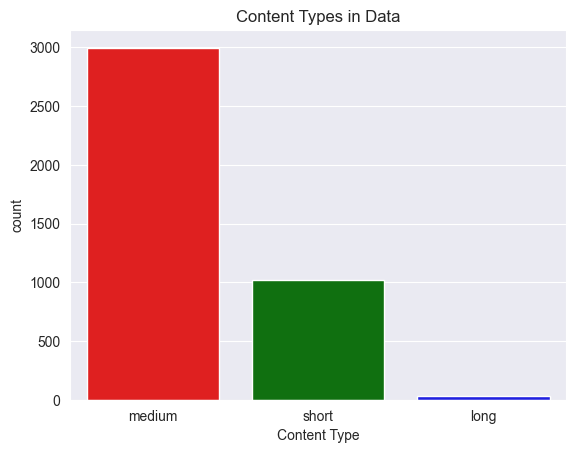

In [14]:
sns.countplot(data=vid_df, x='content_type', palette=['red', 'green', 'blue'])
plt.title('Content Types in Data')
plt.xlabel('Content Type')
plt.show()

We can see that the majority of our data is categorized as **medium** length, meaning most of our videos have a run time between 1 minute and an hour.

## III. Video Titles
***
Video titles can greatly impact a video's success in the current age of YouTube, in conjunction with thumbnails. The mechanisms behind YouTube's video recommendation system tends to favor those with flashy titles, and as a result creator's will often modify their video titles shortly after posting them to improve their performance. This can result in patterns in video titles, as creator's optimize their content for the sake of reaching a wider audience.
Please note that in the case of some creators that most several or more videos daily, such as News shows, their titles may be more reflective of current trends than others. Hence, we are essentially taking a look at what video

In this section we will investigate video titles for a sample of creators, and relative to the entire population of our dataset through various NLP techniques. First let's see what words appear most frequently in the population.

In [15]:
from nltk.tokenize import word_tokenize
from itertools import chain
stop_words = list(analyzer.get_stop_words('en'))
stop_words += [i.title() for i in stop_words] # add capitalized versions of stop_words to stop_word list

In [21]:
title_df = vid_df[['video_title', 'channel_name']]
title_df.sample(10)

,video_title,channel_name
1288,Who Got Dirty on Public Transportation? | Dirt...,Dropout
3065,3 SCARY GAMES #101,Markiplier
708,ASMR CONVENIENCE STORE FOOD 다양 편의점 꿀조합 먹방 FIRE...,Hongyu ASMR 홍유
314,Can you change your sleep schedule?,TED-Ed
1372,cool,emma chamberlain
1854,Julius Randle on His Personal Connection with ...,The Tonight Show Starring Jimmy Fallon
372,2 Men Eat Grape Nuts,Rhett & Link
835,How to Make the UFO Burger from Korea | Street...,Babish Culinary Universe
924,Bolsonaro: Last Week Tonight with John Oliver ...,LastWeekTonight
888,Cultural Appropriation Has Gone Too Far,h3h3Productions


In [17]:
def bag_of_words(title: str, remove_stop_words: bool = False):
    title = analyzer.remove_punct(title)
    words = word_tokenize(title)
    if remove_stop_words:
        words = [word for word in words if word not in stop_words]
    return words

def count_words(all_titles: list):
    counter = Counter()
    # flatten list of lists to a single list
    all_words = list(chain(*all_titles))
    for word in all_words:
        if word not in counter.keys():
            counter[word] = 1
        else:
            counter[word] += 1
    return counter

In [18]:
title_df['keywords'] = title_df['video_title'].apply(lambda x: bag_of_words(x, True))
all_titles = title_df['keywords'].tolist()

In [19]:
word_counts_population = count_words(all_titles)
word_counts_population.most_common(10)

[('shorts', 204),
 ('Show', 102),
 ('Game', 93),
 ('vs', 91),
 ('2', 87),
 ('News', 86),
 ('Gaza', 83),
 ('Live', 82),
 ('Tonight', 79),
 ('ASMR', 78)]

Interestingly enough, 'shorts' is the most common word used in titles among our dataset, after removing stop words. Upon inspection, we find that this is because many creators have appended '#shorts' to the end of their title if they are posting a short. So we do have (at least to some degree) a way to tell which videos are shorts, with a fair degree of confidence. Although, it's not likely that all creators choose to do this with their titles.
Apart from 'shorts', we see that words like 'Show', 'Game', 'Live', and 'ASMR' and 'News' are also very commonly used terms in titles in our data. It's quite common for YouTuber's to append their channel name to the end of their video title, which could explain why we see words like these appear most frequently. Overall, it doesn't appear that we can extract much more information from this data due to this fact.

In [20]:
word_counts_population.most_common(len(word_counts_population))[10:30]

[('Video', 66),
 ('John', 62),
 ('Week', 61),
 ('2023', 61),
 ('Last', 58),
 ('5', 57),
 ('Hamas', 57),
 ('Can', 54),
 ('Course', 53),
 ('Shorts', 52),
 ('Made', 51),
 ('THE', 51),
 ('New', 51),
 ('Oliver', 51),
 ('Crash', 51),
 ('Numberphile', 50),
 ('House', 49),
 ('Israel', 49),
 ('Ariana', 49),
 ('Grande', 49)]